# Creating a Binary Classifier

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from copy import deepcopy
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

# Step 1 Make Data

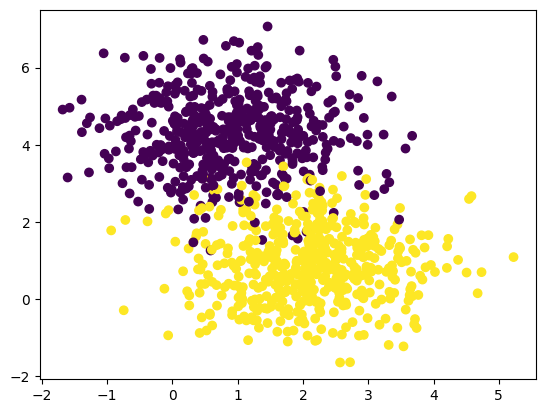

In [2]:
# make 2 blobs of data using sklearn
data = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1.0, random_state=0)

plt.scatter(data[0][:,0], data[0][:,1], c=data[1])
plt.show()

# Make Pytorch Dataset

In [3]:
x = data[0]
y = data[1]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(f"Training data shape: {x_train.shape}, label shape: {y_train.shape}")
print(f"Validation data shape: {x_val.shape}, label shape: {y_val.shape}")
print(f"Test data shape: {x_test.shape}, label shape: {y_test.shape}")

Training data shape: (720, 2), label shape: (720,)
Validation data shape: (80, 2), label shape: (80,)
Test data shape: (200, 2), label shape: (200,)


In [4]:
# set batch size to 10, meaning that every 10 samples will be grouped together as a batch for processing
batch_size = 10

# create train and test data classes
train_data = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# instantiate data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# print out the shapes of the data
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

720 80 200


In [5]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 10)
        self.output = nn.Linear(10, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.output(x)
        return x

In [6]:
def train_binary_classification(model, data_loader, optimizer, criterion, device):
    model.to(device).train()
    batch_loss = []
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x).squeeze(1)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        correct += (y_hat > 0.5).eq(y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy


def validate_binary_classification(model, val_loader, objective, device):
    model.eval()
    batch_loss = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x).squeeze(1)
            loss = objective(y_hat, y)
            batch_loss.append(loss.item())
            correct += (y_hat > 0.5).eq(y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

def evaluate_binary_classification(model, data_loader, device):
    model.to(device).eval()
    correct = 0
    total_samples = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.squeeze(0).to(device)
            y_hat = model(x).squeeze(1)
            predictions.append(y_hat > 0.5)
            actuals.append(y)
            correct += (y_hat > 0.5).eq(y).sum().item()
            total_samples += y.size(0)

    predictions = torch.cat(predictions, dim=0).cpu().numpy()
    actuals = torch.cat(actuals, dim=0).cpu().numpy()
    accuracy = 100.0 * correct / total_samples

    return predictions, actuals, accuracy

class EarlyStopper:
    def __init__(
        self, patience: int = 1, min_delta: float = 0.0, verbose: bool = False
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.best_model_weights = None
        self.verbose = verbose

    def early_stop(self, loss, model):
        if self.verbose:
            print(f"Early Stopping counter: {self.counter} out of {self.patience}")
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [7]:
# lists to store loss and accuracy
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# training lists and parameters
n_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate model, loss function and optimizer
model = NeuralNet(x_train.shape[1], 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0.01)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [8]:
for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    epoch_train_loss, epoch_train_acc = train_binary_classification(model, train_loader, optimizer, criterion, device)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_acc)

    epoch_val_loss, epoch_val_acc = validate_binary_classification(model, val_loader, criterion, device)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_acc)

    print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} acc: {epoch_train_acc:.2f}% - Val loss: {epoch_val_loss:.4f} acc: {epoch_val_acc:.2f}%')
    if early_stopper.early_stop(epoch_val_loss, model):
        early_stopper.restore_best_weights(model)
        print("Early Stopping triggered: Restoring best weights")
        break

Training Progress:   3%|▎         | 3/100 [00:00<00:10,  9.19it/s]

[1/100] Train loss: 0.1991 acc: 90.42% - Val loss: 0.1294 acc: 96.25%
[2/100] Train loss: 0.1421 acc: 93.89% - Val loss: 0.1414 acc: 96.25%
[3/100] Train loss: 0.1426 acc: 93.61% - Val loss: 0.1278 acc: 96.25%


Training Progress:   5%|▌         | 5/100 [00:00<00:09, 10.36it/s]

[4/100] Train loss: 0.1245 acc: 94.44% - Val loss: 0.1967 acc: 95.00%
[5/100] Train loss: 0.1264 acc: 95.14% - Val loss: 0.1096 acc: 95.00%
[6/100] Train loss: 0.1504 acc: 93.61% - Val loss: 0.1280 acc: 95.00%


Training Progress:   9%|▉         | 9/100 [00:00<00:08, 11.32it/s]

[7/100] Train loss: 0.1513 acc: 93.89% - Val loss: 0.1340 acc: 95.00%
[8/100] Train loss: 0.1656 acc: 94.03% - Val loss: 0.1938 acc: 96.25%
[9/100] Train loss: 0.1239 acc: 95.42% - Val loss: 0.1136 acc: 95.00%


Training Progress:   9%|▉         | 9/100 [00:00<00:09,  9.57it/s]

[10/100] Train loss: 0.1561 acc: 94.44% - Val loss: 0.1316 acc: 96.25%
Early Stopping triggered: Restoring best weights


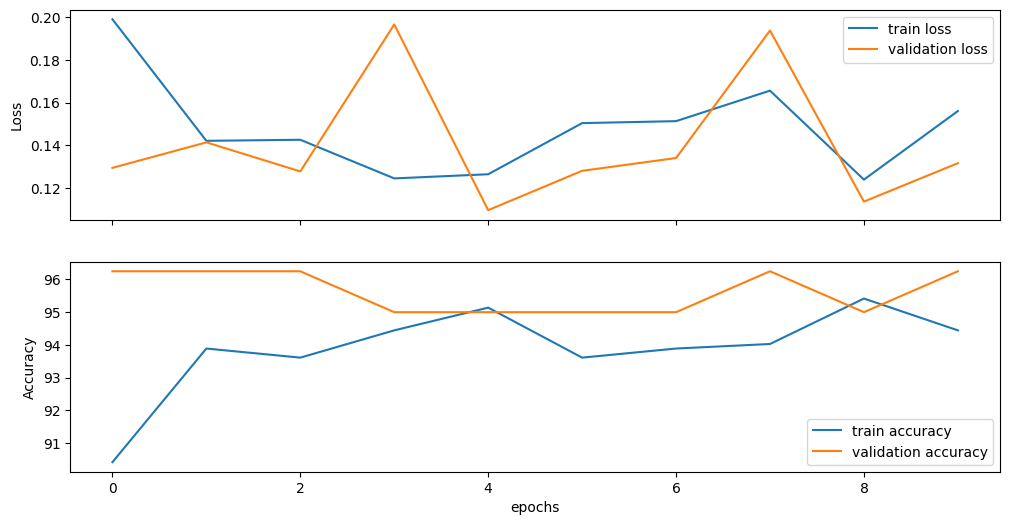

In [9]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(train_loss, label="train loss")
ax1.plot(val_loss, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_accuracy, label="train accuracy")
ax2.plot(val_accuracy, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()

In [10]:
# predict on test data
predictions, actuals, accuracy = evaluate_binary_classification(model, test_loader, device)
print(f"Accuracy on test data: {accuracy:.2f}%")
print(f"The predictions are: {predictions}")

Accuracy on test data: 90.50%
The predictions are: [False False False  True  True  True False False  True  True False False
 False  True False  True  True False False False  True False  True  True
 False False  True  True False  True False False False  True False  True
 False False False  True False False  True False  True  True  True False
 False  True False  True  True  True False  True False False False False
  True  True False False False  True  True False  True  True  True  True
  True  True False  True False  True  True False  True  True  True False
 False False False False False  True False False  True False  True False
 False  True False  True  True False  True  True False False False  True
 False False  True False False False False  True False False False False
 False False  True  True  True False  True  True  True False False False
 False  True  True False  True False False  True  True  True  True False
 False False False False False False False  True  True  True  True False
